In [1]:
import os
from os import path
from datetime import datetime
import pickle
import pytz
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from scipy.io import mmwrite

from utils.parsing import load_properties, hour_rounder
from utils.plotting import color_graph_by_attribute
from utils.assortativity import calc_weighted_attrib_assortativity, calc_weighted_attrib_assortativity_sig

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

## Initial data loading and parsing

In [2]:
# Dataset ID
# A few examples: 34 (CMU), 39 (BYU), 165 (WKU), 195 (PSI 2025), 200 (Murdoch 2025), 799 (Bunbury HS)
dataset_id = 202

# Format of the dataset, options are the follow:
# 0 - old OO simulations
# 1 - prod OO simulations
# 2 - research OO simulations
# 3 - epigames
data_format = 3

In [3]:
# Settings for data analysis

# Discard transmissions when the infected node was already infected before
discard_reinfections = True

# Default contact time for transmissions that are missing an associated contact event
def_contact_time = 1

# Time delta for animation in seconds, needs to be small in comparison with the total length of the 
# simulation so the changes in the animation are smooth
anim_time_step_min = 10
anim_time_delta_sec = anim_time_step_min * 60

# Time delta for plots in some "natural" time step, for examply, hourly or daily
nat_time_step_min = 24 * 60
nat_time_delta_sec = nat_time_step_min * 60

min_total_contact_time = 0.16  # at least this total time (in minutes) over the two weeks to be defined as in contact
min_total_contact_count = 1 # nodes must have at least this number of edges with other nodes to be kept

# Print warning messages to the console when parsing data
print_data_warnings = False

In [4]:
data_folder = path.join('./data', str(dataset_id))
output_folder = path.join('./output', str(dataset_id))
if not path.exists(output_folder):
    os.makedirs(output_folder)

# Load time properties, which need to be in the file time.properties
# under the data folder with the following structure:
# sim_tz=Europe/London
# time0=Jun 30 2025 8:30AM
# time1=Jun 30 2025 5:30PM
tprops_filename = path.join(data_folder, "time.properties")
tprops = load_properties(tprops_filename)
sim_tz = tprops['sim_tz']
time0 = tprops['time0']
time1 = tprops['time1']

print('Time zone =', sim_tz)
print('Start time =', time0)
print('End time =', time1)

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)
obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))

Time zone = Asia/Baghdad
Start time = Nov 16 2025 8:00AM
End time = Nov 30 2025 8:00PM


In [5]:
if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
else:
    tmin = min_time
    tmax = max_time

In [6]:
# frame = 0
# t = tmin
# frame = 0
# while t <= tmax:
#     t0 = t
#     t += nat_time_delta_sec
#     frame += 1
# print(frame + 1)

num_nat_intervals = int((nat_time_delta_sec + tmax - tmin) / nat_time_delta_sec + 1)
num_nat_intervals

16

In [7]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv"), low_memory=False) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"), low_memory=False)
    
users = all_users[all_users["sim_id"] == dataset_id].copy()
if data_format < 2:
    if data_format < 1:
        users['random_id'] = users['id']
else:
    users['random_id'] = users['random_id'].astype(str).str.zfill(4)

# Save the users to a pickle file
with open(path.join(data_folder, 'users.pickle'), 'wb') as f:
    pickle.dump(users, f)

if data_format == 1:
    events = all_events
else:
    events = all_events[all_events["sim_id"] == dataset_id].copy()
    
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

First event: 2025-11-15 15:00:00+03:00
Last event : 2025-12-01 18:00:00+03:00
Start time: 2025-11-16 08:00:00
End time: 2025-11-30 20:00:00
Asia/Baghdad
567
567
567
567


In [8]:
# Utility functions

def plot_and_calc_corr(df, v1, v2):
    df_clean = df.dropna(subset=[v1, v2])
    plt.hist2d(df_clean[v1], df_clean[v2], cmap='viridis')

    spearman_corr, spearman_p = stats.spearmanr(df_clean[v1], df_clean[v2])

    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"P-value: {spearman_p:.4f}")

def compare_dists(data1, data2, label1, label2):
    data1.hist(label=label1, alpha=0.5)
    data2.hist(label=label2, alpha=0.5)
    
    plt.legend() 
    plt.title("Distribution Comparison")
    plt.show()
    
    ks_stat, ks_p = stats.ks_2samp(data1, data2)
    print(f"KS Test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

    mw_stat, mw_p = stats.mannwhitneyu(data1, data2)
    print(f"Mann-Whitney U: statistic={mw_stat:.4f}, p-value={mw_p:.4f}")

    res = stats.anderson_ksamp([data1, data2], method=stats.PermutationMethod())
    print(f"Anderson-Darling: statistic={res.statistic:.4f}, p-value={res.pvalue:.4f}")

    ws_dist = stats.wasserstein_distance(data1, data2)
    print(f"Wasserstein Distance: {ws_dist:.4f}")

In [9]:
users['group'] = users['group'].map({'group1': 1, 'group2': 2})

In [10]:
users

,id,p2p_id,sim_id,group,random_id,score
0,9745,b7a6129b-4897-45e7-ae29-439603f9736d,202,2.0,2750,174
1,9747,0be480d9-78c0-481b-ace4-09230ce6e569,202,1.0,9810,55
2,9744,9c231d69-288d-4054-b8ac-b3976bbcd3d7,202,2.0,6293,133
3,9742,fd876408-76ac-4731-9d5a-43f8a348c4ad,202,NaN,6429,0
4,9755,2be03d55-441f-4958-9793-c93c90fd8806,202,2.0,1856,162
...,...,...,...,...,...,...
562,10301,18dea694-f178-4a67-8e7b-0db3f818f1d6,202,2.0,5467,89
563,10306,11afc9d8-abf4-4c3d-83d8-9bc837193336,202,2.0,9575,0
564,10287,685fcb49-3f36-41a2-8f7b-05124faa25fc,202,2.0,2370,22
565,10264,656ac1c4-2d78-4676-8d76-1603bd945c2a,202,2.0,8725,26


In [11]:
surv_q_id2title = {35:"S1_Q1", 36:"S1_Q2", 37:"S1_Q3", 38:"S1_Q4", 39:"S1_Q5", 40:"S1_Q6",
                   41:"S2_Q1", 42:"S2_Q2", 43:"S2_Q3", 44:"S2_Q4",
                   55:"S3_Q1", 56:"S3_Q2", 57:"S3_Q3", 58:"S3_Q4", 59:"S3_Q5"}

surv_a_lett2num = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6}

In [12]:
all_survey_answers = pd.read_csv(path.join(data_folder, "survey-answers.csv"), low_memory=False) 

In [13]:
survey_answers = all_survey_answers[all_survey_answers["sim_id"] == dataset_id]

In [14]:
qid_values = all_survey_answers.question_id.values
uid_values = all_survey_answers.user_id.values
ans_values = all_survey_answers.value.values

In [15]:
for k in surv_q_id2title:
    users[surv_q_id2title[k]] = np.nan
users['quarantine'] = np.nan
users['no_quarantine'] = np.nan

In [16]:
for uid, qid, ans in zip(uid_values, qid_values, ans_values):
    indices = users.index[users['id'] == uid].tolist()
    qcol = surv_q_id2title[qid]
    qval = surv_a_lett2num[ans]    
    for idx in indices:
        users.at[idx, qcol] = qval

In [17]:
# Remove events before a certain date

# tloc = timezone.localize(datetime.strptime('Nov 19 2025 8:30PM', '%b %d %Y %I:%M%p'))
# tstop = datetime.timestamp(tloc)
# events = events[events['time'] < tstop].copy()

In [18]:
qevents = events[(events['inf'] == 'quarantine')]
nqevents = events[(events['inf'] == 'noQuarantine')]

for uid in users.id.values:
    indices = users.index[users['id'] == uid].tolist()
    qindices = qevents.index[qevents['user_id'] == uid].tolist()
    nqindices = nqevents.index[nqevents['user_id'] == uid].tolist()    
    for idx in indices:
        users.at[idx, 'quarantine'] = len(qindices)
        users.at[idx, 'no_quarantine'] = len(nqindices)

In [19]:
# Remove users who did not ever pick quarantine

condition = (users['quarantine'] == 0) & (users['no_quarantine'] == 0)
users = users[~condition].copy()

In [20]:
dates = []
quarantine_no = []
quarantine_yes = []

t = tmin
day = 0
print('Calculating quarantine/no quarantine each day of the sim...')
while t <= tmax:
    t0 = t
    t += nat_time_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
    
    # We want to include events that ocurred between t0 and t
    condition = (t0 < events['time']) & (events['time'] <= t)

    tevents = events[condition]
    qtevents = tevents[(tevents['inf'] == 'quarantine')]
    nqtevents = tevents[(tevents['inf'] == 'noQuarantine')]

    date = datetime.fromtimestamp(t0, tz=timezone).strftime('%Y-%m-%d')
    
    users[f'quarantine_day{day}'] = np.nan
    users[f'no_quarantine_day{day}'] = np.nan
    for uid in users.id.values:
        indices = users.index[users['id'] == uid].tolist()
        qindices = qtevents.index[qtevents['user_id'] == uid].tolist()
        nqindices = nqtevents.index[nqtevents['user_id'] == uid].tolist()    
        for idx in indices:
            users.at[idx, f'quarantine_day{day}'] = len(qindices)
            users.at[idx, f'no_quarantine_day{day}'] = len(nqindices)

    date = datetime.fromtimestamp(t0, tz=timezone).strftime('%Y-%m-%d')
    qno = len(nqtevents)
    qyes = len(qtevents)

    print(f'day {day}', date, qno, qyes)

    dates.append(date)
    quarantine_no.append(qno)
    quarantine_yes.append(qyes)    
    
    day += 1
print('Done')

daily_behaviors = pd.DataFrame({'date': dates, 
                                'quarantine_no': quarantine_no, 
                                'quarantine_yes': quarantine_yes})

Calculating quarantine/no quarantine each day of the sim...
day 0 2025-11-16 0 0
day 1 2025-11-17 216 43
day 2 2025-11-18 190 27
day 3 2025-11-19 217 25
day 4 2025-11-20 70 8
day 5 2025-11-21 98 12
day 6 2025-11-22 38 0
day 7 2025-11-23 111 4
day 8 2025-11-24 102 11
day 9 2025-11-25 145 11
day 10 2025-11-26 113 7
day 11 2025-11-27 53 1
day 12 2025-11-28 30 2
day 13 2025-11-29 25 0
day 14 2025-11-30 112 4
Done


In [21]:
users

,id,p2p_id,sim_id,group,random_id,score,S1_Q1,S1_Q2,S1_Q3,S1_Q4,...,quarantine_day10,no_quarantine_day10,quarantine_day11,no_quarantine_day11,quarantine_day12,no_quarantine_day12,quarantine_day13,no_quarantine_day13,quarantine_day14,no_quarantine_day14
0,9745,b7a6129b-4897-45e7-ae29-439603f9736d,202,2.0,2750,174,6.0,6.0,5.0,6.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9747,0be480d9-78c0-481b-ace4-09230ce6e569,202,1.0,9810,55,4.0,5.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9744,9c231d69-288d-4054-b8ac-b3976bbcd3d7,202,2.0,6293,133,2.0,3.0,6.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9755,2be03d55-441f-4958-9793-c93c90fd8806,202,2.0,1856,162,3.0,2.0,3.0,6.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,9748,e54d6694-a312-479e-8fe9-3305bd69bbc9,202,2.0,4324,213,2.0,2.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,10298,932d2b38-0127-49d3-abc3-317b455f6446,202,1.0,2532,38,3.0,3.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562,10301,18dea694-f178-4a67-8e7b-0db3f818f1d6,202,2.0,5467,89,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
564,10287,685fcb49-3f36-41a2-8f7b-05124faa25fc,202,2.0,2370,22,2.0,4.0,5.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,10264,656ac1c4-2d78-4676-8d76-1603bd945c2a,202,2.0,8725,26,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Descriptive plots

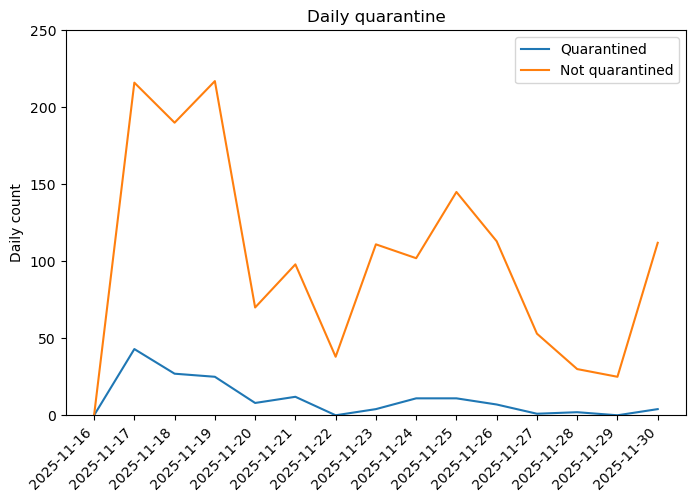

In [22]:
behaviors = ['quarantine_yes', 'quarantine_no']
labels = ['Quarantined', 'Not quarantined']
maxc = 250
plt.figure(figsize=(8, 5))
plt.title('Daily quarantine')

for b, t in zip(behaviors, labels):
    plt.plot(daily_behaviors['date'], daily_behaviors[b], label=t)

plt.xticks(rotation=45, ha='right')
plt.ylim(0, maxc)
plt.ylabel('Daily count')

plt.legend()
    
plt.savefig(path.join(output_folder, 'daily-behavior.pdf'), bbox_inches='tight')
plt.show()    

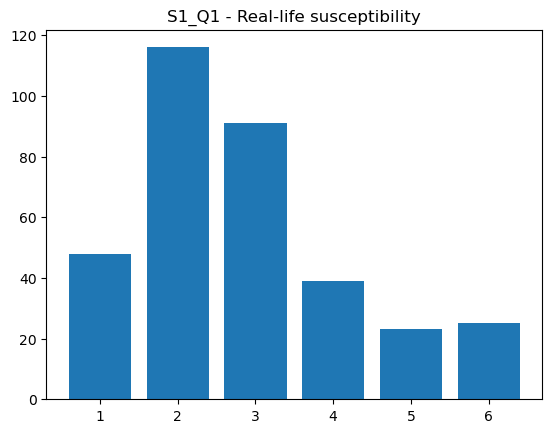

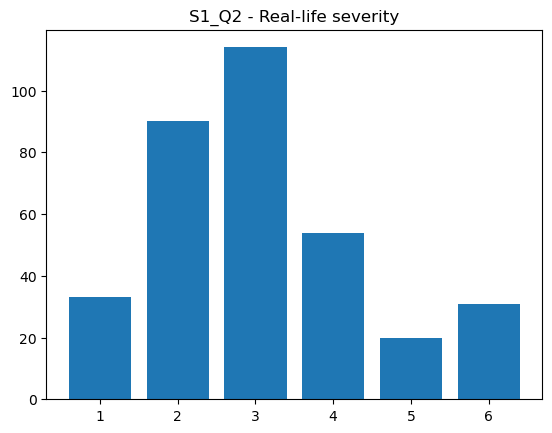

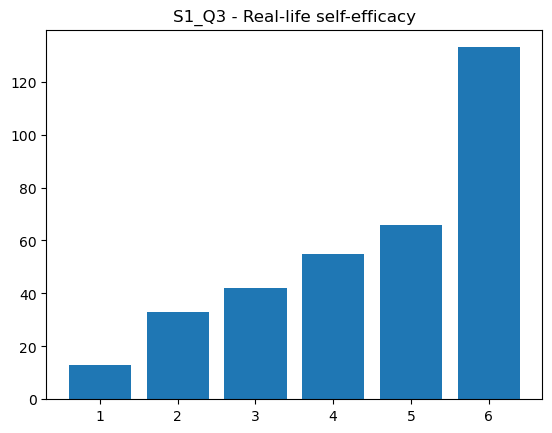

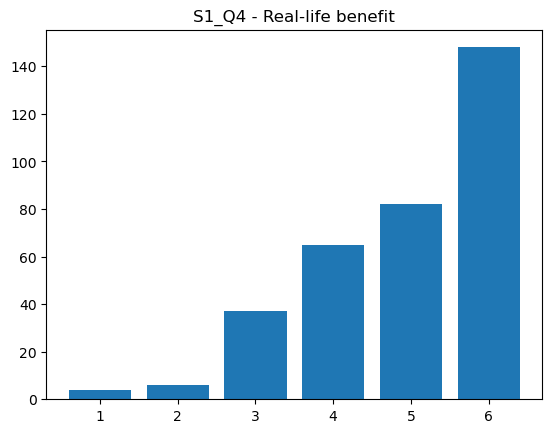

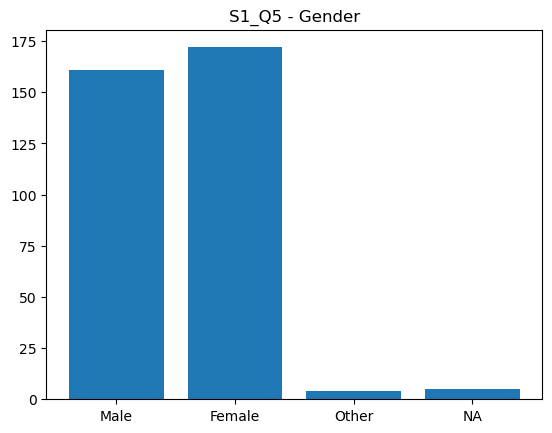

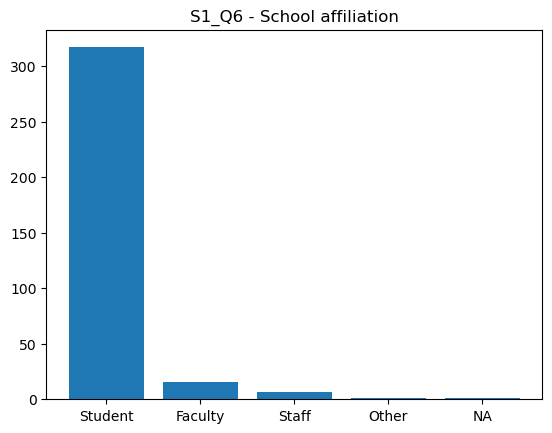

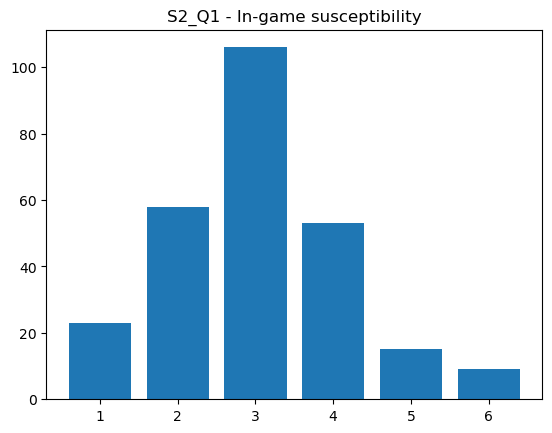

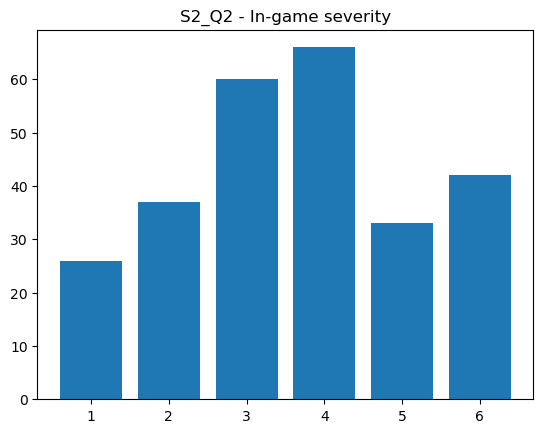

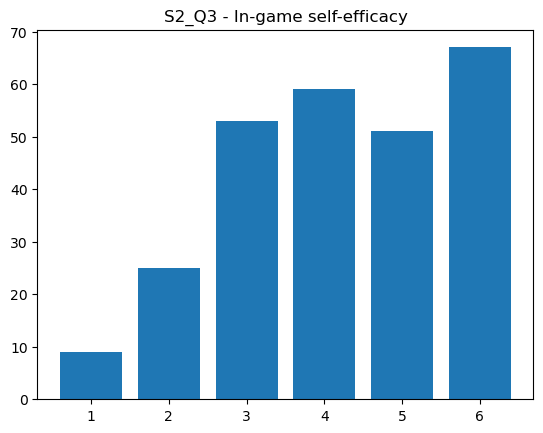

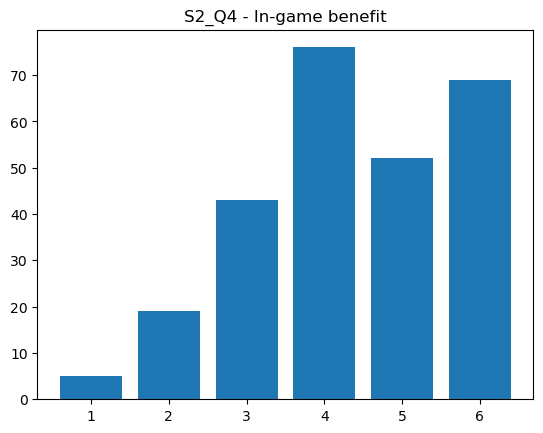

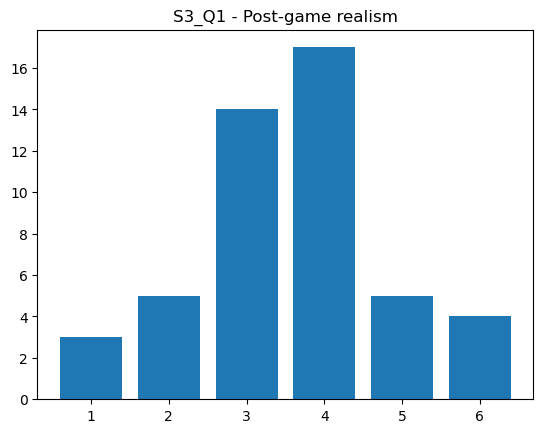

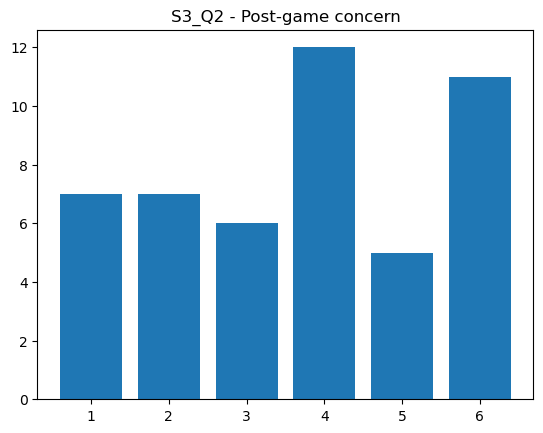

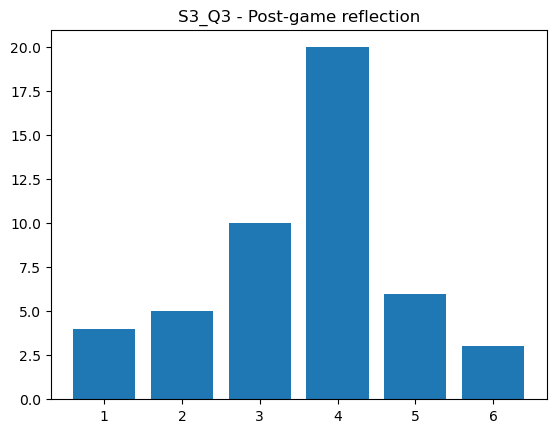

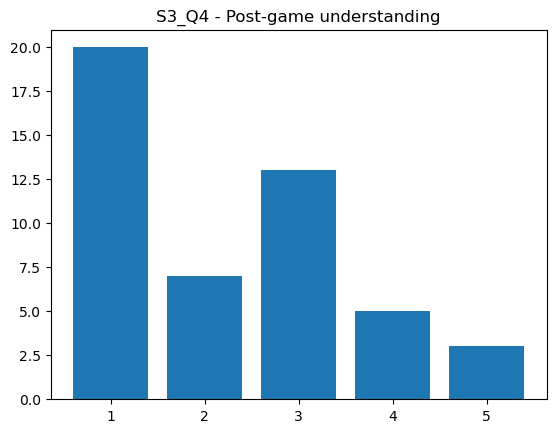

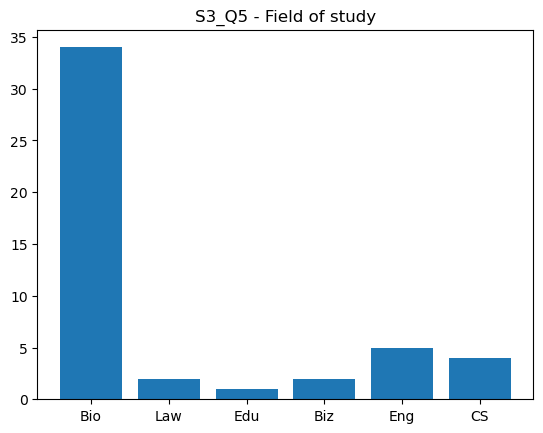

In [23]:
topic_map = {
 'S1_Q1': 'Real-life susceptibility', 
 'S1_Q2': 'Real-life severity', 
 'S1_Q3': 'Real-life self-efficacy', 
 'S1_Q4': 'Real-life benefit', 
 'S1_Q5': 'Gender', 
 'S1_Q6': 'School affiliation', 
 'S2_Q1': 'In-game susceptibility', 
 'S2_Q2': 'In-game severity', 
 'S2_Q3': 'In-game self-efficacy', 
 'S2_Q4': 'In-game benefit',
 'S3_Q1': 'Post-game realism', 
 'S3_Q2': 'Post-game concern', 
 'S3_Q3': 'Post-game reflection', 
 'S3_Q4': 'Post-game understanding',
 'S3_Q5': 'Field of study'
}

gender_labels = ['Male', 'Female', 'Other', 'NA']
gender_ticks = [1, 2, 3, 4]

affiliation_labels = ['Student', 'Faculty', 'Staff', 'Other', 'NA']
affiliation_ticks = [1, 2, 3, 4, 5]

field_labels = ['Bio', 'Law', 'Edu', 'Biz', 'Eng', 'CS']
field_ticks = [1, 2, 3, 4, 5, 6]

for var in list(surv_q_id2title.values()):
    # 1. Get min and max to define the range
    min_val = int(users[var].min())
    max_val = int(users[var].max())
    
    # 2. Define bins at half-integers (e.g., 0.5, 1.5, ... 6.5)
    # We add +2 to max_val to ensure the right edge of the last bin is included
    bins = np.arange(min_val, max_val + 2) - 0.5
    
    # 3. Plot
    # rwidth=0.8 creates the gap (bars use only 80% of the bin width)
    users.hist(column=var, bins=bins, rwidth=0.8, grid=False)
    plt.title(var + ' - ' + topic_map[var])

    if var == 'S1_Q5':
        plt.xticks(gender_ticks, gender_labels)
    elif var == 'S1_Q6':
        plt.xticks(affiliation_ticks, affiliation_labels)
    elif var == 'S3_Q5':
        plt.xticks(field_ticks, field_labels)        
    else:
        plt.xticks(range(min_val, max_val + 1))
    
    plt.savefig(path.join(output_folder, var + '.pdf'), bbox_inches='tight')
    plt.show()

## Statistical analyses of groups and survey responses

In [24]:
users_g1 = users[users['group'] == 1]
len(users_g1)

184

In [25]:
users_g2 = users[users['group'] == 2]
len(users_g2)

214

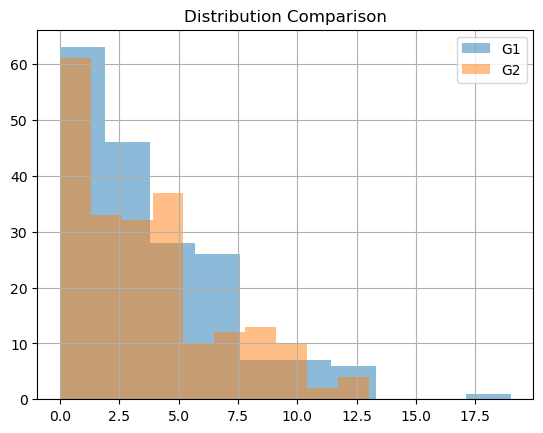

KS Test: statistic=0.0573, p-value=0.8753
Mann-Whitney U: statistic=18979.5000, p-value=0.5312
Anderson-Darling: statistic=-0.4983, p-value=0.5613
Wasserstein Distance: 0.2551


In [26]:
compare_dists(users_g1['no_quarantine'], users_g2['no_quarantine'], 'G1', 'G2')

Spearman Correlation: -0.1019
P-value: 0.0597


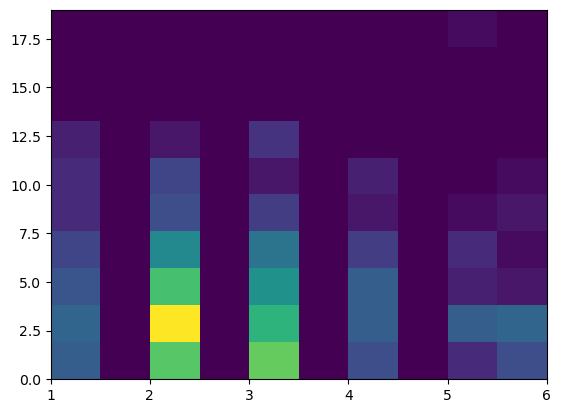

In [27]:
plot_and_calc_corr(users, 'S1_Q1', 'no_quarantine')

Spearman Correlation: 0.0258
P-value: 0.6342


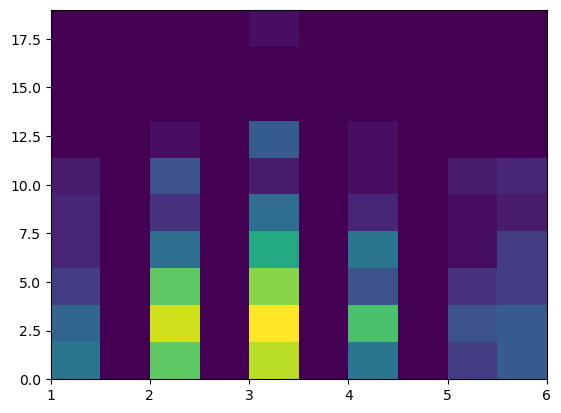

In [28]:
plot_and_calc_corr(users, 'S1_Q2', 'no_quarantine')

Spearman Correlation: 0.0185
P-value: 0.7329


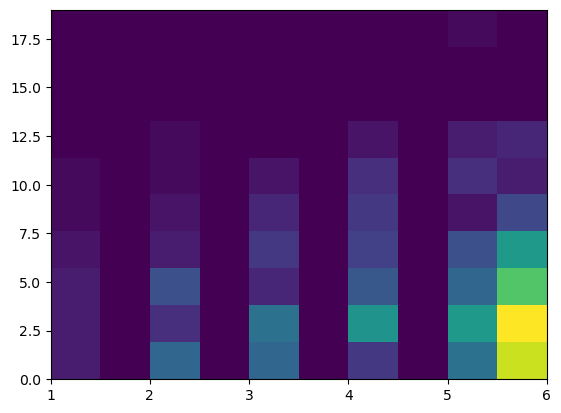

In [29]:
plot_and_calc_corr(users, 'S1_Q3', 'no_quarantine')

Spearman Correlation: 0.0273
P-value: 0.6147


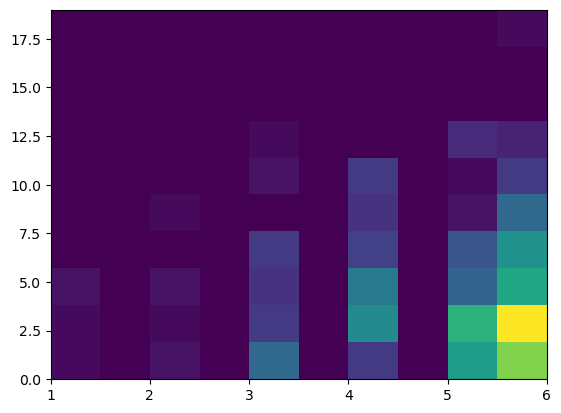

In [30]:
plot_and_calc_corr(users, 'S1_Q4', 'no_quarantine')

Spearman Correlation: 0.0682
P-value: 0.2081


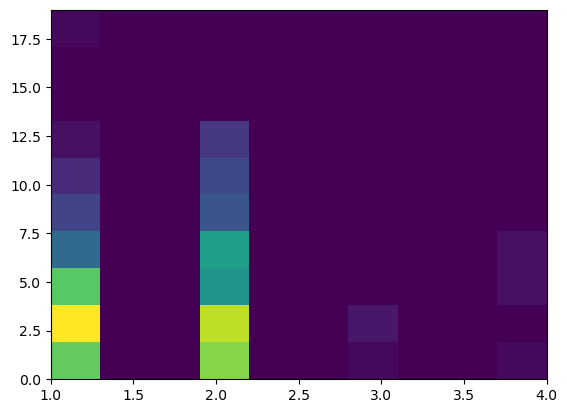

In [31]:
plot_and_calc_corr(users, 'S1_Q5', 'no_quarantine')

Spearman Correlation: 0.2057
P-value: 0.0001


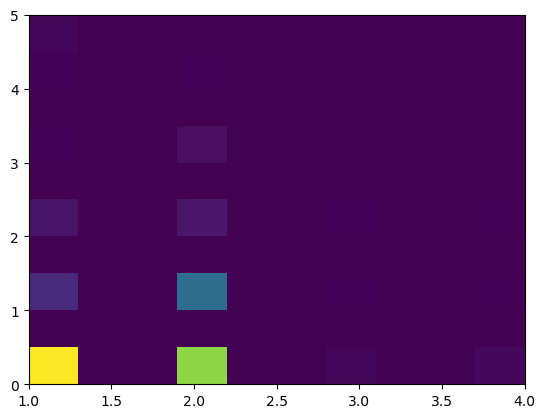

In [32]:
plot_and_calc_corr(users, 'S1_Q5', 'quarantine')

Spearman Correlation: 0.1597
P-value: 0.0479


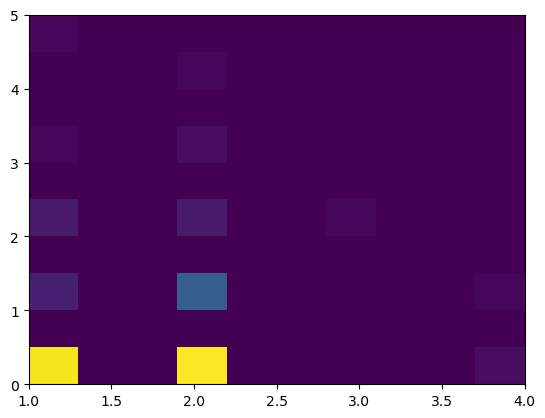

In [33]:
plot_and_calc_corr(users_g1, 'S1_Q5', 'quarantine')

Spearman Correlation: 0.2462
P-value: 0.0010


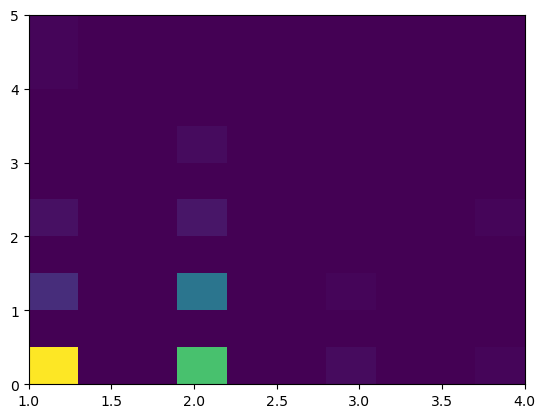

In [34]:
plot_and_calc_corr(users_g2, 'S1_Q5', 'quarantine')

## Some more G1-G2 comparisons among subgroups

In [35]:
# Male students
musers = users[users['S1_Q5'] == 1]
musers_g1 = musers[musers['group'] == 1]
musers_g2 = musers[musers['group'] == 2]

In [36]:
# Female students
fusers = users[users['S1_Q5'] == 2]
fusers_g1 = fusers[fusers['group'] == 1]
fusers_g2 = fusers[fusers['group'] == 2]

In [37]:
# Students in non-biology-related majors
nbusers = users[users['S3_Q5'] > 2]
nbusers_g1 = nbusers[nbusers['group'] == 1]
nbusers_g2 = nbusers[nbusers['group'] == 2]

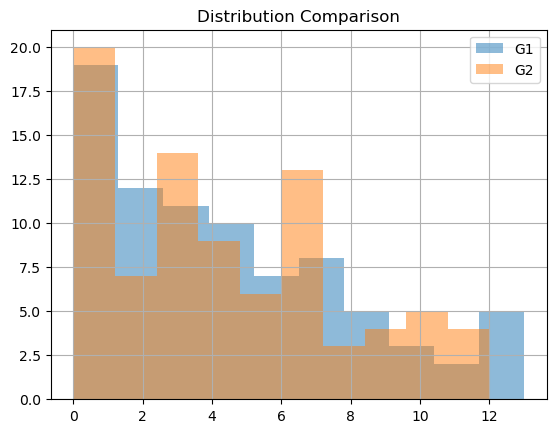

KS Test: statistic=0.0604, p-value=0.9941
Mann-Whitney U: statistic=3456.0000, p-value=0.9268
Anderson-Darling: statistic=-1.0813, p-value=0.9460
Wasserstein Distance: 0.2445


In [38]:
compare_dists(fusers_g1['no_quarantine'], fusers_g2['no_quarantine'], 'G1', 'G2')

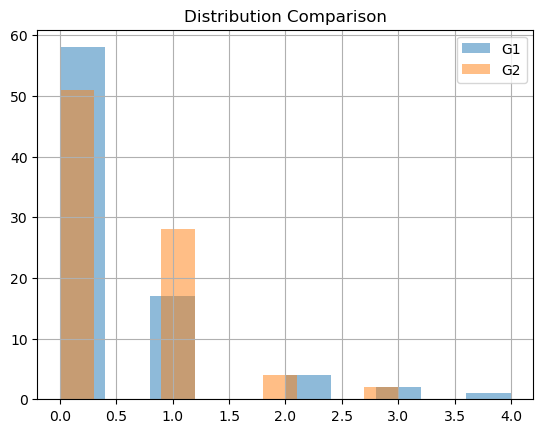

KS Test: statistic=0.1073, p-value=0.6652
Mann-Whitney U: statistic=3161.0000, p-value=0.2165
Anderson-Darling: statistic=0.8564, p-value=0.1869
Wasserstein Distance: 0.1473


In [39]:
compare_dists(fusers_g1['quarantine'], fusers_g2['quarantine'], 'G1', 'G2')

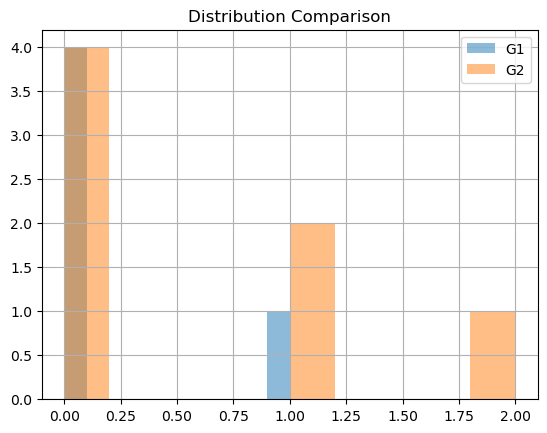

KS Test: statistic=0.2286, p-value=0.9899
Mann-Whitney U: statistic=13.0000, p-value=0.4350
Anderson-Darling: statistic=-0.4512, p-value=0.4874
Wasserstein Distance: 0.3714


In [40]:
compare_dists(nbusers_g1['quarantine'], nbusers_g2['quarantine'], 'G1', 'G2')

In [41]:
eff_thres = 3
users_g2_hi_eff = fusers_g2[fusers_g2['S1_Q3'] > eff_thres]
users_g2_lo_eff = fusers_g2[fusers_g2['S1_Q3'] <= eff_thres]

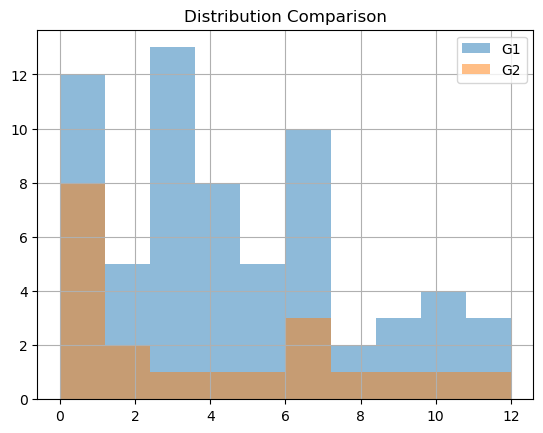

KS Test: statistic=0.2385, p-value=0.3001
Mann-Whitney U: statistic=744.0000, p-value=0.3294
Anderson-Darling: statistic=0.4937, p-value=0.2227
Wasserstein Distance: 0.7115


In [42]:
compare_dists(users_g2_hi_eff['no_quarantine'], users_g2_lo_eff['no_quarantine'], 'G1', 'G2')

In [43]:
users_g2_hi_eff['no_quarantine'].median()

np.float64(4.0)

In [44]:
users_g2_lo_eff['no_quarantine'].median()

np.float64(2.5)

Spearman Correlation: -0.1706
P-value: 0.0253


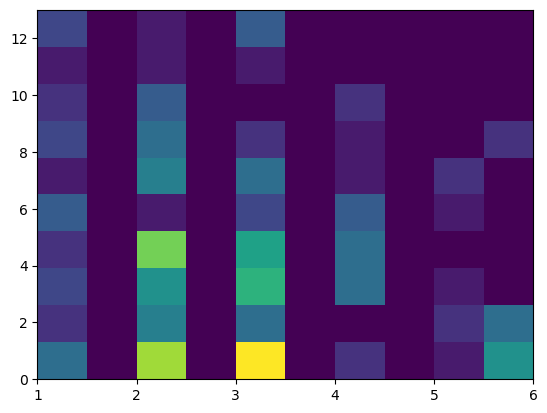

In [45]:
plot_and_calc_corr(fusers, 'S1_Q1', 'no_quarantine')

Spearman Correlation: 0.1827
P-value: 0.0165


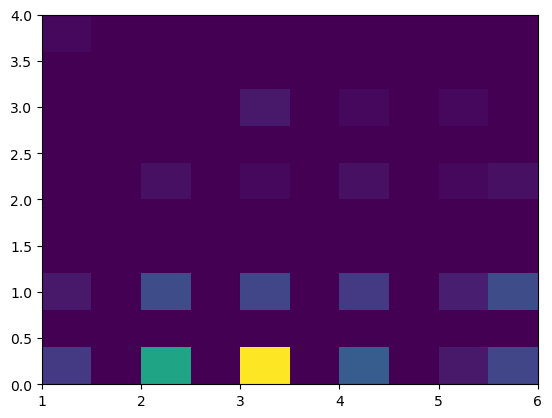

In [46]:
plot_and_calc_corr(fusers, 'S1_Q2', 'quarantine')

Spearman Correlation: -0.0397
P-value: 0.6050


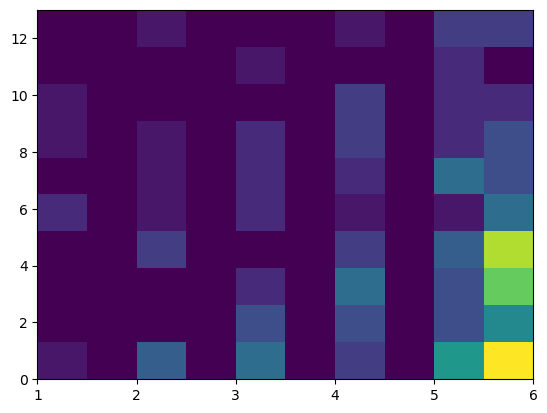

In [47]:
plot_and_calc_corr(fusers, 'S1_Q3', 'no_quarantine')

Spearman Correlation: 0.0034
P-value: 0.9646


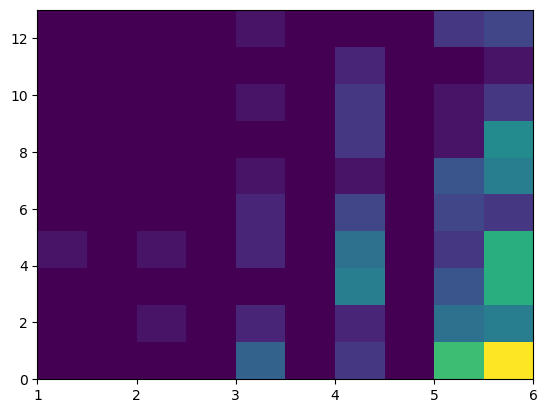

In [48]:
plot_and_calc_corr(fusers, 'S1_Q4', 'no_quarantine')

## Correlation between real-life and game attitudes

Spearman Correlation: 0.2002
P-value: 0.0012


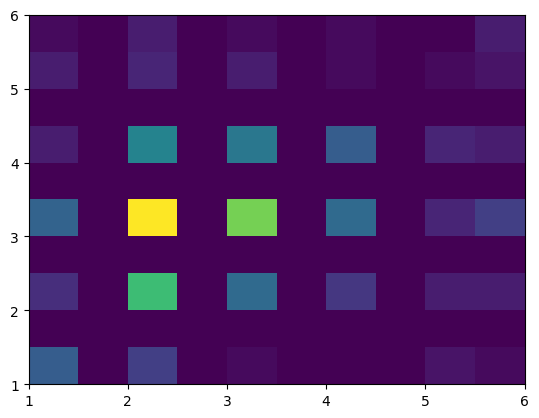

In [49]:
plot_and_calc_corr(users, 'S1_Q1', 'S2_Q1')

Spearman Correlation: 0.1289
P-value: 0.0386


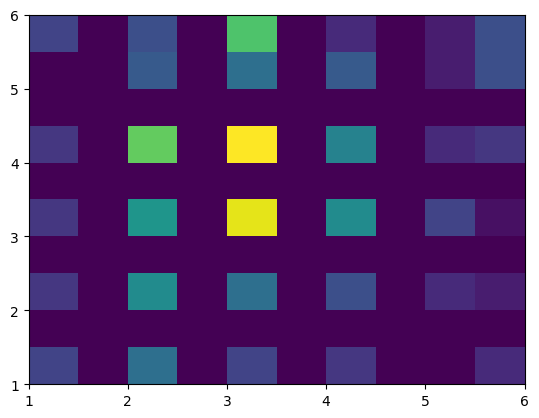

In [50]:
plot_and_calc_corr(users, 'S1_Q2', 'S2_Q2')

Spearman Correlation: 0.2687
P-value: 0.0000


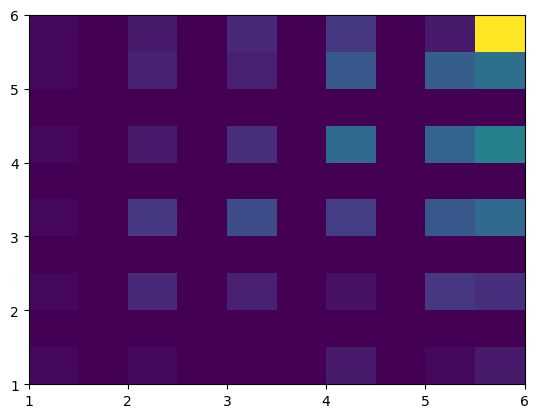

In [51]:
plot_and_calc_corr(users, 'S1_Q3', 'S2_Q3')

Spearman Correlation: 0.3578
P-value: 0.0000


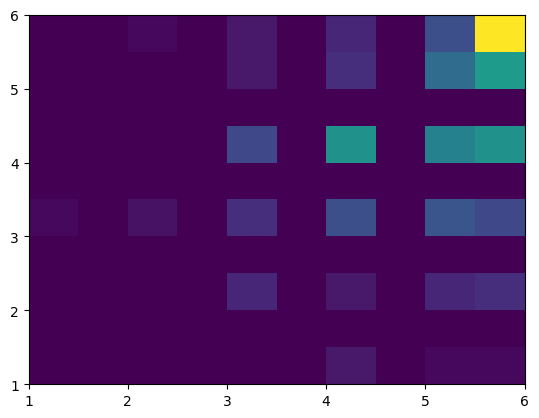

In [52]:
plot_and_calc_corr(users, 'S1_Q4', 'S2_Q4')

## Linear models

In [56]:
df1 = users[['quarantine', 'no_quarantine', 'S1_Q1', 'S1_Q2', 'S1_Q3', 'S1_Q4', 'S1_Q5', 'group']].copy() 
df1.dropna(inplace=True)

# Anchoring variables to minimum (0) so the intercept can be interpreted as the probability of 
# quarantine for a hypothetical particpant who responded 1 to all surveys
df1['S1_Q1'] = df1['S1_Q1'] - 1
df1['S1_Q2'] = df1['S1_Q2'] - 1
df1['S1_Q3'] = df1['S1_Q3'] - 1
df1['S1_Q4'] = df1['S1_Q4'] - 1
df1['S1_Q5'] = df1['S1_Q5'] - 1

df2 = users[['quarantine', 'no_quarantine', 'S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4', 'S1_Q5', 'group']].copy() 
df2.dropna(inplace=True)

df2['S2_Q1'] = df2['S2_Q1'] - 1
df2['S2_Q2'] = df2['S2_Q2'] - 1
df2['S2_Q3'] = df2['S2_Q3'] - 1
df2['S2_Q4'] = df2['S2_Q4'] - 1
df2['S1_Q5'] = df2['S1_Q5'] - 1

In [57]:
print("\n\n--- H1 model (main effect from group assignment) ---")

formula = 'quarantine ~ group'
poisson_model_h1 = smf.glm(formula=formula, data=df1, family=sm.families.Poisson()).fit()
print(poisson_model_h1.summary())



--- H1 model (main effect from group assignment) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             quarantine   No. Observations:                  330
Model:                            GLM   Df Residuals:                      328
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -285.89
Date:                Sat, 06 Dec 2025   Deviance:                       376.89
Time:                        18:30:06   Pearson chi2:                     533.
No. Iterations:                     5   Pseudo R-squ. (CS):          5.118e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [58]:
print("\n\n--- H1B model (using S2 dataset) ---")

formula = 'quarantine ~ group'
poisson_model_h1b = smf.glm(formula=formula, data=df2, family=sm.families.Poisson()).fit()
print(poisson_model_h1b.summary())



--- H1B model (using S2 dataset) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             quarantine   No. Observations:                  250
Model:                            GLM   Df Residuals:                      248
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -225.04
Date:                Sat, 06 Dec 2025   Deviance:                       303.07
Time:                        18:30:10   Pearson chi2:                     428.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.002438
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

In [59]:
print("\n\n--- H2 model (interaction of S1 attitudes with group) ---")

formula = 'quarantine ~ (S1_Q1 + S1_Q2 + S1_Q3 + S1_Q4 + S1_Q5) * C(group)'
poisson_model_h2 = smf.glm(formula=formula, data=df1, family=sm.families.Poisson()).fit()
print(poisson_model_h2.summary())



--- H2 model (interaction of S1 attitudes with group) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             quarantine   No. Observations:                  330
Model:                            GLM   Df Residuals:                      318
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -277.85
Date:                Sat, 06 Dec 2025   Deviance:                       360.81
Time:                        18:30:13   Pearson chi2:                     586.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04761
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [60]:
print("\n\n--- H2B model (using S2 dataset) ---")

formula = 'quarantine ~ (S2_Q1 + S2_Q2 + S2_Q3 + S2_Q4 + S1_Q5) * C(group)'
poisson_model_h2b = smf.glm(formula=formula, data=df2, family=sm.families.Poisson()).fit()
print(poisson_model_h2b.summary())



--- H2B model (using S2 dataset) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             quarantine   No. Observations:                  250
Model:                            GLM   Df Residuals:                      238
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.83
Date:                Sat, 06 Dec 2025   Deviance:                       280.66
Time:                        18:30:14   Pearson chi2:                     431.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08796
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

## Data anomalies

In [71]:
infections = events[events["type"] == "infection"]
ilist = {}
for uid, t in zip(infections.user_id.values, infections.time.values):
    ilist[uid] = t

illness = events[events["type"] == "illness"]
slist = {}
for uid, t, i in zip(illness.user_id.values, illness.time.values, illness.inf.values):
    if i == 'symptomatic':
        slist[uid] = t

devices = events.query('type == "modifier" and modifier.str.contains("model:")')
dlist = {}
ios_count = 0
android_count = 0
for uid, dev in zip(devices.user_id.values, devices.modifier.values):
    dlist[uid] = dev
    if 'iPhone' in dev or 'iPad' in dev:
        ios_count += 1
    else:
        android_count += 1

outcomes = events[events["type"] == "outcome"]
elist = {}
qlist = {}
escaped_on_ios = 0
escaped_on_android = 0
for uid, t, o in zip(outcomes.user_id.values, outcomes.time.values, outcomes.out.values):
    if o == 'ESCAPED':        
        elist[uid] = t
        if uid in dlist:
            if 'iPhone' in dlist[uid] or 'iPad' in dlist[uid]:
                escaped_on_ios += 1
            else:
                escaped_on_android += 1
    if o == 'QUIT':
        qlist[uid] = t

for uid in ilist:
    if uid in elist and ilist[uid] < elist[uid]:
        print(uid, 'escaped after becoming infected')
    if uid in qlist and ilist[uid] < qlist[uid]:
        print(uid, 'quit after becoming infected')

print('Participants using iOS devices =', ios_count)
print('Participants using Android devices =', android_count)
print('Infected =', len(ilist))
print('Symptomatic =', len(slist))
print('Escaped =', len(elist))
print('Escaped using iOS device =', escaped_on_ios)
print('Escaped using Android device =', escaped_on_android)
print('Quit =', len(qlist))        

10036 escaped after becoming infected
9857 escaped after becoming infected
9974 escaped after becoming infected
9892 escaped after becoming infected
Participants using iOS devices = 402
Participants using Android devices = 197
Infected = 52
Symptomatic = 5
Escaped = 145
Escaped using iOS device = 97
Escaped using Android device = 66
Quit = 10


## Network analysis

In [107]:
with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

with open(path.join(data_folder, 'network-node-positions.pickle'), 'rb') as f:
    Gpos = pickle.load(f)    

In [108]:
attribs_to_add = [
    'quarantine', 'no_quarantine', 'group',
    'S1_Q1', 'S1_Q2', 'S1_Q3', 'S1_Q4', 'S1_Q5',
    'S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4',
    'S3_Q1', 'S3_Q2', 'S3_Q3', 'S3_Q4', 'S3_Q5'
]

# Filter and reindex by keeping only the rows corresponding to nodes in the graph.
# It automatically creates rows with NaN values for any node in G that is not found in the users dataframe.
node_attributes_df = users[attribs_to_add].reindex(G.nodes())

# Add to graph in one go:
# to_dict('index') converts the dataframe to: {node_id: {'col1': val, 'col2': val...}}
nx.set_node_attributes(G, node_attributes_df.to_dict('index'))

In [109]:
# Adds the prediction from the Poisson model as another attribute in the graph

# Initialize the dictionary with NaN for all nodes in the graph
prediction_dict = {node: np.nan for node in G.nodes()}

# Identify nodes that are in the graph and have complete data by checking 
# intersection of indices and dropping rows with missing values in required columns
required_cols = ['S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4', 'S1_Q5', 'group']
valid_mask = users.index.isin(G.nodes())
df_clean = users.loc[valid_mask, required_cols].dropna()

if not df_clean.empty:
    # 3. Create a copy to apply preprocessing safely
    df_for_prediction = df_clean.copy()

    # 4. Re-apply the "Anchoring" (Minus 1) exactly as you did for training
    cols_to_anchor = ['S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4', 'S1_Q5']
    for col in cols_to_anchor:
        df_for_prediction[col] = df_for_prediction[col] - 1

    # 5. Generate Predictions
    preds = poisson_model_h2b.predict(df_for_prediction)

    # 6. Update the dictionary 
    # This only updates keys that exist in 'preds'; the rest stay NaN
    prediction_dict.update(preds.to_dict())

nx.set_node_attributes(G, prediction_dict, 'predicted_quarantine')

attribs_to_add.append('predicted_quarantine')

In [110]:
# Assortativity calculation using the DescrStatsW from statsmodels.stats.weightstats
# and the p-value using bootstrapping
for attrib in attribs_to_add:
    rho = calc_weighted_attrib_assortativity(G, attrib)
    pval = calc_weighted_attrib_assortativity_sig(G, attrib, rho, 10000)
    print(f'Assortativity value for {attrib} = {rho:.2f} (p-value = {pval:.5f})')

Assortativity value for quarantine = 0.08 (p-value = 0.20870)
Assortativity value for no_quarantine = 0.46 (p-value = 0.00110)
Assortativity value for group = -0.11 (p-value = 0.75870)
Assortativity value for S1_Q1 = 0.23 (p-value = 0.05020)
Assortativity value for S1_Q2 = 0.18 (p-value = 0.09960)
Assortativity value for S1_Q3 = -0.00 (p-value = 0.50480)
Assortativity value for S1_Q4 = 0.04 (p-value = 0.38060)
Assortativity value for S1_Q5 = 0.34 (p-value = 0.00770)
Assortativity value for S2_Q1 = 0.07 (p-value = 0.31330)
Assortativity value for S2_Q2 = 0.40 (p-value = 0.00680)
Assortativity value for S2_Q3 = 0.15 (p-value = 0.16860)
Assortativity value for S2_Q4 = 0.48 (p-value = 0.00180)
Assortativity value for S3_Q1 = -0.40 (p-value = 0.93900)
Assortativity value for S3_Q2 = 0.01 (p-value = 0.49050)
Assortativity value for S3_Q3 = 0.20 (p-value = 0.21310)
Assortativity value for S3_Q4 = -0.31 (p-value = 0.87470)
Assortativity value for S3_Q5 = 0.34 (p-value = 0.10080)
Assortativity 

In [74]:
weights = list(nx.get_edge_attributes(G, 'weight').values())
wmin = np.min(weights)/2
wmax = np.max(weights)
edge_weights = [pow((w - wmin)/(wmax-wmin), 0.35) for w in weights] 

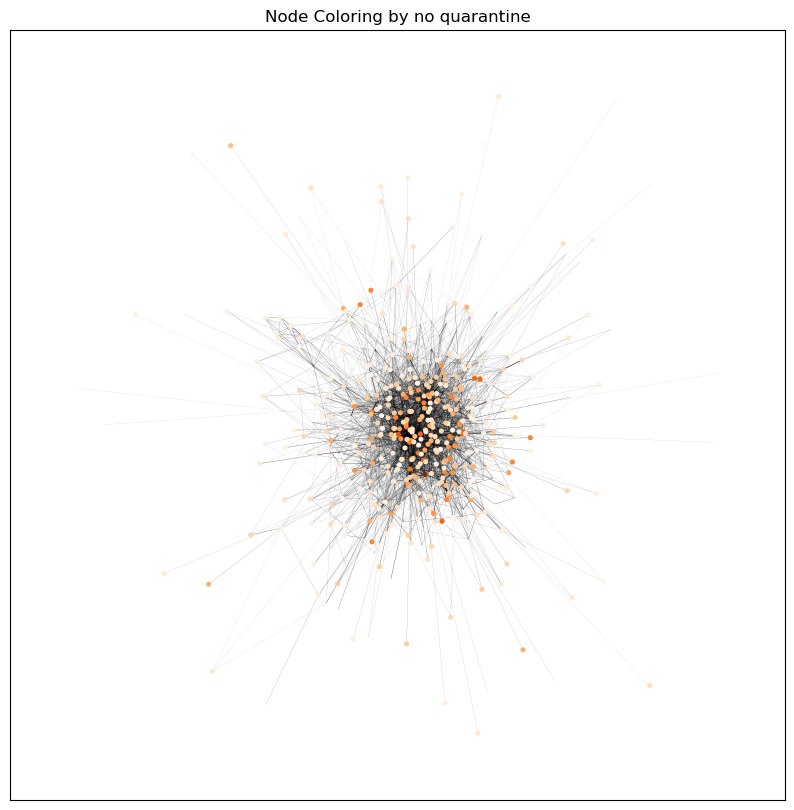

In [75]:
wm_dict = nx.get_node_attributes(G, 'no_quarantine')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by no quarantine', edge_weights)

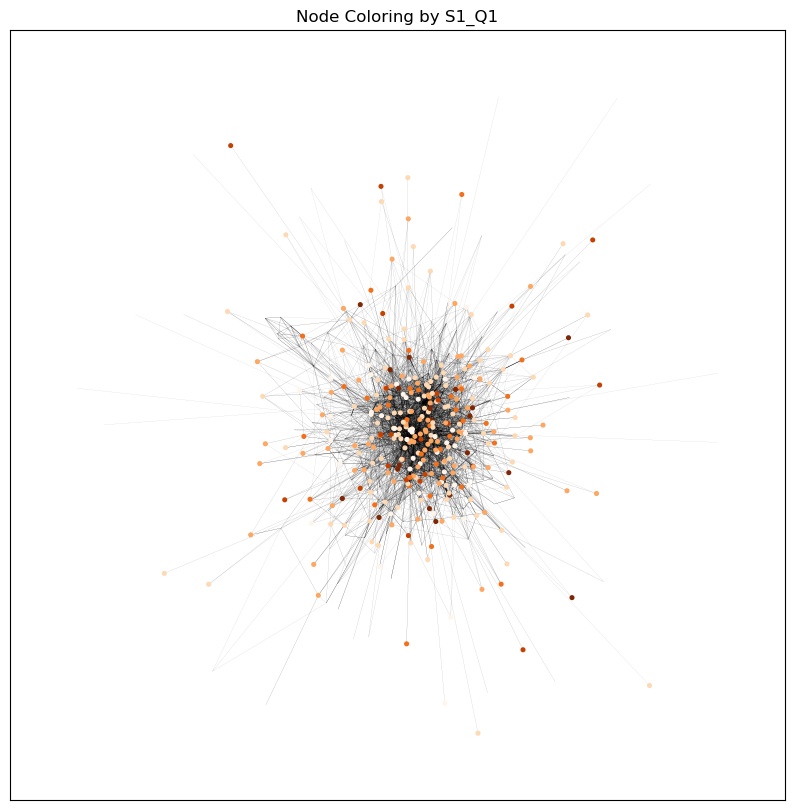

In [76]:
wm_dict = nx.get_node_attributes(G, 'S1_Q1')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by S1_Q1', edge_weights)

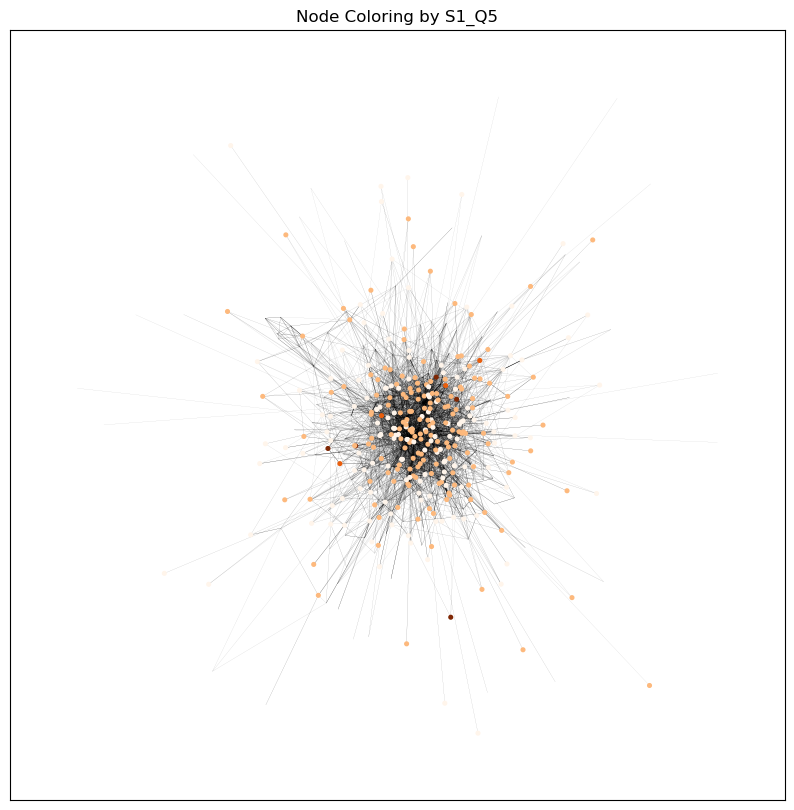

In [77]:
wm_dict = nx.get_node_attributes(G, 'S1_Q5')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by S1_Q5', edge_weights)

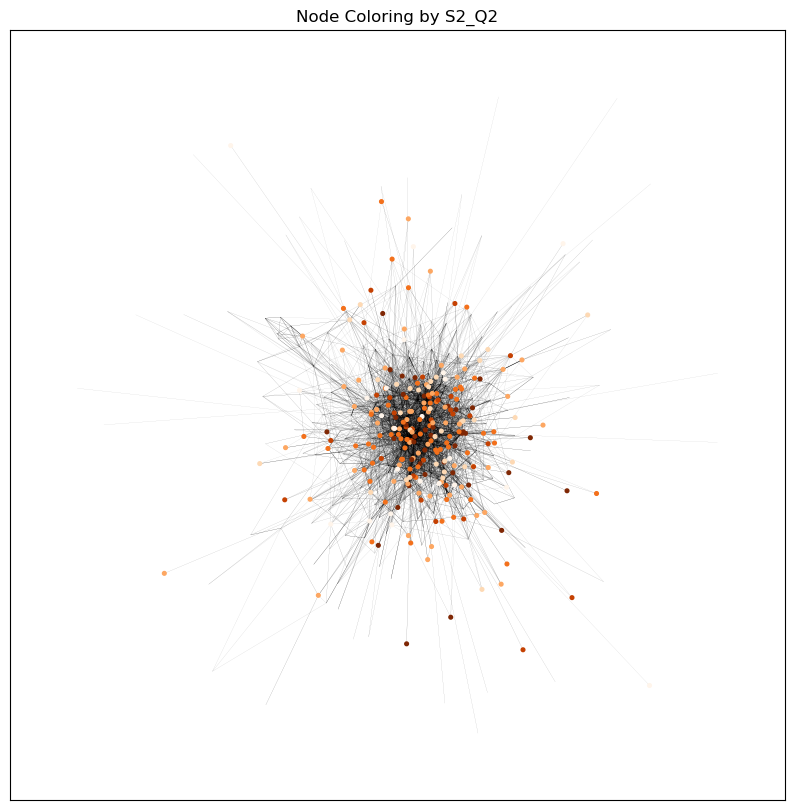

In [78]:
wm_dict = nx.get_node_attributes(G, 'S2_Q2')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by S2_Q2', edge_weights)

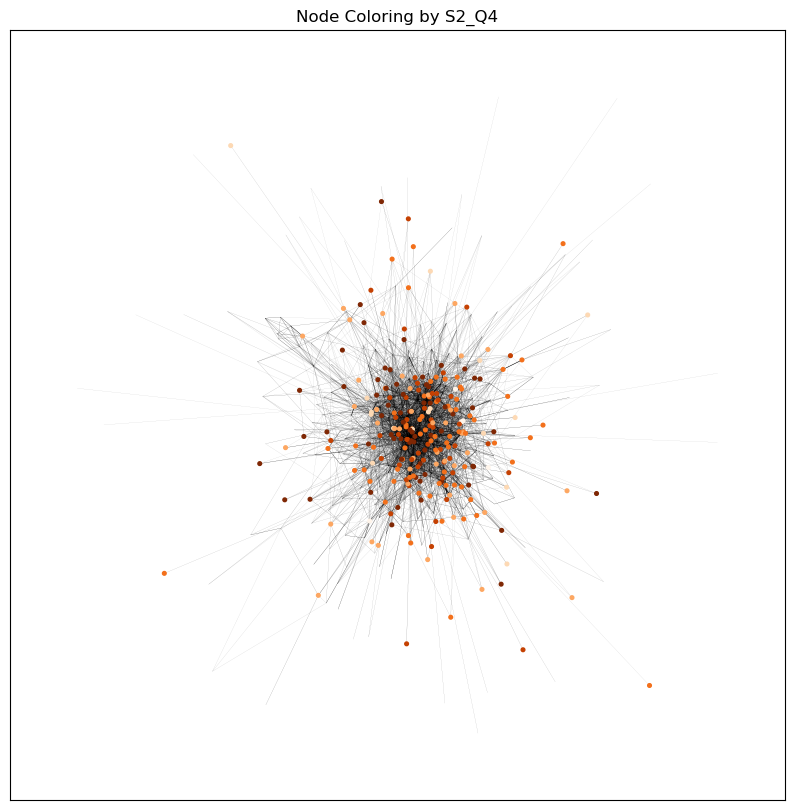

In [79]:
wm_dict = nx.get_node_attributes(G, 'S2_Q4')
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by S2_Q4', edge_weights)

## HBM analysis

In [124]:
# Calculate the Total Trials (N) and the Rate (Y)
users['total_trials'] = users['quarantine'] + users['no_quarantine']
users['quarantine_rate'] = users['quarantine'] / users['total_trials']

In [125]:
df_hbm = users[['quarantine_rate', 'total_trials', 'S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4', 'S1_Q5', 'group']].copy() 
df_hbm.dropna(inplace=True)

df_hbm['S2_Q1'] = df_hbm['S2_Q1'] - 1
df_hbm['S2_Q2'] = df_hbm['S2_Q2'] - 1
df_hbm['S2_Q3'] = df_hbm['S2_Q3'] - 1
df_hbm['S2_Q4'] = df_hbm['S2_Q4'] - 1
df_hbm['S1_Q5'] = df_hbm['S1_Q5'] - 1

In [126]:
hbm_formula = """
quarantine_rate ~ (S2_Q1 + S2_Q2 + S2_Q3 + S2_Q4 + S1_Q5) * C(group)
"""

In [127]:
# Family: Binomial (for probabilities)
# var_weights: total_trials (tells the model how much weight to give each row)
hbm_model = smf.glm(
    formula=hbm_formula, 
    data=df_hbm, 
    family=sm.families.Binomial(), 
    var_weights=df_hbm['total_trials']
).fit()

In [128]:
print(hbm_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        quarantine_rate   No. Observations:                  250
Model:                            GLM   Df Residuals:                      238
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -289.26
Date:                Sat, 06 Dec 2025   Deviance:                       347.49
Time:                        20:21:35   Pearson chi2:                     600.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09898
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.09

In [136]:
df_map = users[['S1_Q1', 'S1_Q2', 'S1_Q3', 'S1_Q4', 'S2_Q1', 'S2_Q2', 'S2_Q3', 'S2_Q4', 'S3_Q1', 'S3_Q2', 'S3_Q3', 'S3_Q4']].copy() 
df_map.dropna(inplace=True)
df_map = df_map - 1

In [139]:
# ---------------------------------------------------------
# 1. Define the Variable Mappings
# ---------------------------------------------------------
# We want to predict In-Game (S2) using Real-Life (S1) + Post-Game (S3) controls.
# Mapping:
# S2_Q1 (Susceptibility) <- S1_Q1
# S2_Q2 (Severity)       <- S1_Q2
# S2_Q3 (Self Efficacy)  <- S1_Q3
# S2_Q4 (Benefits)       <- S1_Q4

models_to_run = [
    {'target': 'S2_Q1', 'predictor': 'S1_Q1', 'label': 'Susceptibility'},
    {'target': 'S2_Q2', 'predictor': 'S1_Q2', 'label': 'Severity'},
    {'target': 'S2_Q3', 'predictor': 'S1_Q3', 'label': 'Self-Efficacy'},
    {'target': 'S2_Q4', 'predictor': 'S1_Q4', 'label': 'Benefits'}
]

# Control Variables (Post-game perceptions)
# S3_Q1: Realism, S3_Q2: Concern, S3_Q3: Reflection, S3_Q4: Understanding
controls = "S3_Q1 + S3_Q2 + S3_Q3 + S3_Q4"

In [142]:
# ---------------------------------------------------------
# 2. Loop through and Fit Models
# ---------------------------------------------------------
results = {}

print("--- PREDICTING IN-GAME ATTITUDES (S2) FROM REAL-LIFE (S1) & CONTROLS (S3) ---\n")

for model_info in models_to_run:
    target = model_info['target']
    predictor = model_info['predictor']
    label = model_info['label']
    
    # Construct Formula: S2_Qx ~ S1_Qx + S3_Vars
    formula = f"{target} ~ {predictor} + {controls}"
    
    # Fit OLS Model
    # We use df_map (assuming it contains all S1, S2, S3 columns)
    model = smf.ols(formula=formula, data=df_map).fit()
    
    # Store and Print
    results[label] = model
    
    print(f"=== MODEL: {label.upper()} ({target}) ===")
    print(f"Formula: {formula}")
    print(f"R-squared: {model.rsquared:.3f}")
    
    # Extract key coefficients to show the 'link' between Real-Life and In-Game
    s1_coef = model.params[predictor]
    s1_pval = model.pvalues[predictor]
    print(f"Real-Life Predictor ({predictor}): Coef={s1_coef:.3f}, P-value={s1_pval:.3f}")
    
    # Check if Realism (S3_Q1) matters (often a key validator)
    if 'S3_Q1' in model.params:
        realism_coef = model.params['S3_Q1']
        realism_pval = model.pvalues['S3_Q1']
        print(f"Perceived Realism (S3_Q1):   Coef={realism_coef:.3f}, P-value={realism_pval:.3f}")

    # print(model.summary())
    
    print("-" * 50 + "\n")

--- PREDICTING IN-GAME ATTITUDES (S2) FROM REAL-LIFE (S1) & CONTROLS (S3) ---

=== MODEL: SUSCEPTIBILITY (S2_Q1) ===
Formula: S2_Q1 ~ S1_Q1 + S3_Q1 + S3_Q2 + S3_Q3 + S3_Q4
R-squared: 0.023
Real-Life Predictor (S1_Q1): Coef=0.016, P-value=0.917
Perceived Realism (S3_Q1):   Coef=0.044, P-value=0.816
--------------------------------------------------

=== MODEL: SEVERITY (S2_Q2) ===
Formula: S2_Q2 ~ S1_Q2 + S3_Q1 + S3_Q2 + S3_Q3 + S3_Q4
R-squared: 0.037
Real-Life Predictor (S1_Q2): Coef=0.051, P-value=0.791
Perceived Realism (S3_Q1):   Coef=0.057, P-value=0.807
--------------------------------------------------

=== MODEL: SELF-EFFICACY (S2_Q3) ===
Formula: S2_Q3 ~ S1_Q3 + S3_Q1 + S3_Q2 + S3_Q3 + S3_Q4
R-squared: 0.091
Real-Life Predictor (S1_Q3): Coef=-0.017, P-value=0.905
Perceived Realism (S3_Q1):   Coef=-0.010, P-value=0.963
--------------------------------------------------

=== MODEL: BENEFITS (S2_Q4) ===
Formula: S2_Q4 ~ S1_Q4 + S3_Q1 + S3_Q2 + S3_Q3 + S3_Q4
R-squared: 0.306
Real-L

In [149]:
df_q1 = users[['S1_Q1', 'S2_Q1']].copy() 
df_q1.dropna(inplace=True)
df_q1 = df_q1 - 1
model_q1 = smf.ols(formula='S2_Q1 ~ S1_Q1', data=df_q1).fit()
print(model_q1.summary())

                            OLS Regression Results                            
Dep. Variable:                  S2_Q1   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     10.13
Date:                Sat, 06 Dec 2025   Prob (F-statistic):            0.00164
Time:                        20:46:56   Log-Likelihood:                -394.29
No. Observations:                 258   AIC:                             792.6
Df Residuals:                     256   BIC:                             799.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7375      0.116     15.028      0.0

In [148]:
df_q2 = users[['S1_Q2', 'S2_Q2']].copy() 
df_q2.dropna(inplace=True)
df_q2 = df_q2 - 1
model_q2 = smf.ols(formula='S2_Q2 ~ S1_Q2', data=df_q2).fit()
print(model_q2.summary())

                            OLS Regression Results                            
Dep. Variable:                  S2_Q2   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.652
Date:                Sat, 06 Dec 2025   Prob (F-statistic):             0.0319
Time:                        20:46:54   Log-Likelihood:                -470.64
No. Observations:                 258   AIC:                             945.3
Df Residuals:                     256   BIC:                             952.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2974      0.177     13.012      0.0

In [151]:
df_q3 = users[['S1_Q3', 'S2_Q3']].copy() 
df_q3.dropna(inplace=True)
df_q3 = df_q3 - 1
model_q3 = smf.ols(formula='S2_Q3 ~ S1_Q3', data=df_q3).fit()
print(model_q3.summary())

                            OLS Regression Results                            
Dep. Variable:                  S2_Q3   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     16.31
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           7.10e-05
Time:                        20:47:29   Log-Likelihood:                -450.45
No. Observations:                 258   AIC:                             904.9
Df Residuals:                     256   BIC:                             912.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2946      0.235      9.750      0.0

In [152]:
df_q4 = users[['S1_Q4', 'S2_Q4']].copy() 
df_q4.dropna(inplace=True)
df_q4 = df_q4 - 1
model_q4 = smf.ols(formula='S2_Q4 ~ S1_Q4', data=df_q4).fit()
print(model_q4.summary())

                            OLS Regression Results                            
Dep. Variable:                  S2_Q4   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     30.65
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           7.65e-08
Time:                        20:48:01   Log-Likelihood:                -422.59
No. Observations:                 258   AIC:                             849.2
Df Residuals:                     256   BIC:                             856.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7832      0.291      6.121      0.0

## Dissonance score 

In [161]:
users['dissonance_score'] = ((users['S3_Q3']-1)/5) - users['quarantine_rate']

<Axes: >

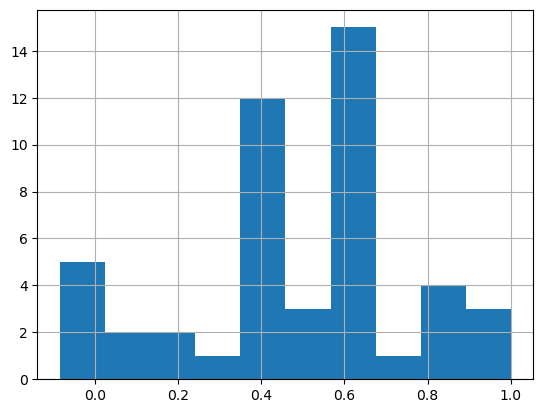

In [162]:
users['dissonance_score'].hist()

Spearman Correlation: -0.1281
P-value: 0.3909


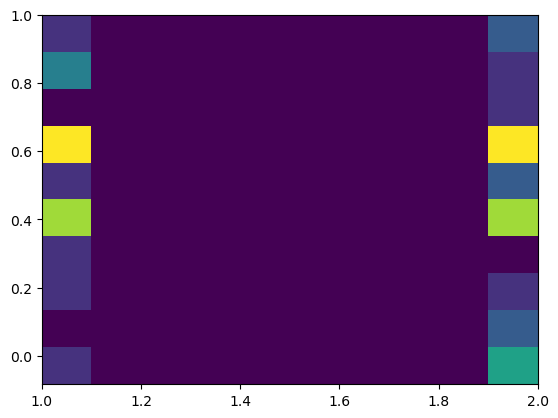

In [165]:
plot_and_calc_corr(users, 'group', 'dissonance_score')

In [166]:
users_g1 = users[users['group'] == 1]
users_g2 = users[users['group'] == 2]

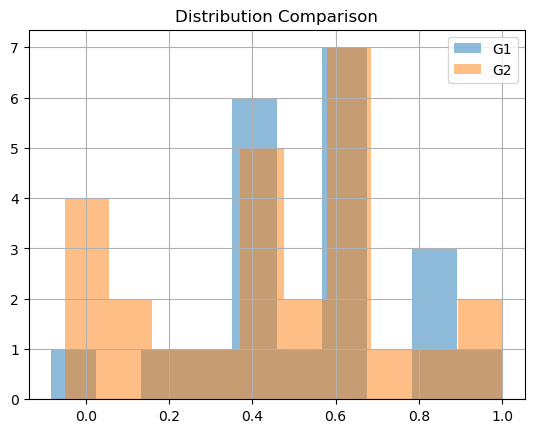

KS Test: statistic=nan, p-value=nan
Mann-Whitney U: statistic=nan, p-value=nan
Anderson-Darling: statistic=-1.1653, p-value=0.8109
Wasserstein Distance: nan


In [167]:
compare_dists(users_g1['dissonance_score'], users_g2['dissonance_score'], 'G1', 'G2')